The goal of the following hands-on excercises is for you to become familiar with basic deep learning concepts.

At the end of the exercises, you should have an understanding of the following ideas:
* multi-layer perceptron (feed-foward neural net)
* loss functions (regression and classification)
* different optimization algorithms
* how to read loss curves
* how to tune hyper-parameters.

Along the way, we will introduce some basic syntax for the `PyTorch` library.

Import some modules we'll use sooner or later.

In [1]:
import torch
import torch.nn as nn

import numpy as np
from matplotlib import pyplot as plt

# progress bars are really nice, use them!
import tqdm

# 1. Defining the architecture

## Primitive building block: the perceptron

We first construct a **Perceptron**.
A perceptron is the fundamental building block of many neural networks.
It performs the following operations on the input `x` sequentially:
1. pass through an affine transformation (`nn.Linear`), which consists of multiplying by a weight and adding a bias.
2. pass through a non-linear activation function. The most popular choice is the rectifying linear unit (`nn.ReLU`).

In `torch`, we need to "register" these operations in the constructor (`__init__`).
This tells `torch` to track gradients with respect to parameters associated with the operations.
Technically speaking, most activation functions (like `nn.ReLU`) don't have trainable parameters.
However, it is still good practice to register them as modules in the constructor.

Tip: the [PyTorch online documentation](https://pytorch.org/docs/stable/index.html) is very well written.
You'll find it useful for the following exercises.

In [2]:
class Perceptron (nn.Module) :
    # Unless we have a more specialized unit, we inherit from nn.Module.
    # This base class performs a lot of magic under the hood to make it easy
    # for us to write neural nets.

    def __init__ (
            self,
            dim_in: int, # input dimensionality
            dim_out: int # output dimensionality
    ) :
        # usually, we need to initialize the base class first
        # The torch Module performs some magic when instance members are added
        super().__init__()
        self.l = nn.Linear(dim_in, dim_out)
        self.activation = nn.ReLU()

    def forward (self, x: torch.Tensor) -> torch.Tensor :
        # torch wraps forward(...) within the __call__ method
        # and takes care of tracing gradients automatically
        return self.activation(self.l(x))

## Feed-foward neural net: multi-layer perceptron

Next, we stack multiple perceptrons into a **Multi-Layer Perceptron (MLP)**.

Each perceptron's output is counted as a *hidden layer*.
The dimensionality of the hidden layers, `dim_hidden`, is a hyperparameter and not constrained
by the input or output dimensionality.

Hints:
1. the output of your MLP should in principle cover the entire space.\
   The output of activation functions like ReLU does not, in general.
2. You'll need to be a bit careful when registering lists of perceptrons in the constructor.\
   PyTorch doesn't know that an ordinary list contains modules it should care about.\
   Look at the documentation for `nn.Sequential` or `nn.ModuleList`.

In [3]:
class MultiLayerPerceptron (nn.Module) :

    def __init__ (
        self,
        dim_in: int, # input dimensionality
        dim_out: int, # output dimensionality
        N_hidden: int, # number of hidden layers
        dim_hidden: int, # dimensionality of hidden layers
    ) :
        super().__init__()
        self.perceptrons = nn.Sequential(
            *[
                Perceptron(
                    dim_hidden if ii else dim_in,
                    dim_hidden
                )
                for ii in range(N_hidden)
            ]
        )
        self.fc = nn.Linear(dim_hidden, dim_out)

    def forward (self, x: torch.Tensor) -> torch.Tensor :
        return self.fc(self.perceptrons(x))

Let's make sure that everything is set up correctly. The following should execute without error.

In [18]:
test_dim_in = 4
test_dim_out = 3
test_N_hidden = 5
test_dim_hidden = 6
test_batch_size = 32

test_model = MultiLayerPerceptron(test_dim_in, test_dim_out, test_N_hidden, test_dim_hidden)
test_x = torch.ones(test_batch_size, test_dim_in)
test_y = test_model(test_x)
test_loss = test_y.sum()
test_loss.backward()

# 2. Regression in one dimension

The first exercise will be to learn a simple one-dimesional function.
We consider the function $f(x) = \sin(\pi x)$ on the domain $x \in [-1, 1]$.

Note that even in this simple example we need to be very careful about specifying the domain!
Neural networks are generally not very good at out-of-domain tasks.

In [4]:
def target_fct (x: torch.Tensor) -> torch.Tensor :
    return (torch.pi * x).sin()

## Model and Loss

Let's construct an MLP to learn this function.

We'll start with a single hidden layer. What kind of model would our network be equivalent to if there were no hidden layer at all?

Let's start with a single hidden unit.

In [5]:
regressor = MultiLayerPerceptron(dim_in=1, dim_out=1, N_hidden=1, dim_hidden=1)

In order to train this model, we need to specify a **loss function**.

The loss function depends on the kind of problem you want to solve.

In this case, it is a *regression problem* (we're trying to fit a function $f(x)$).
A popular choice for regression is the mean squared error loss (MSE), defined as
$l_{MSE}(y_1, y_2) = \frac{1}{N}\sum(y_1 - y_2)^2$,
element-wise.

In [6]:
loss_fct = nn.MSELoss()

## Preliminaries for training

Let's write down the basic set of hyper parameters for the training. You can play with these later.

In [7]:
learning_rate = 1e-2
batch_size = 128
N_steps = 4096

`PyTorch` provides optimizers out of the box in the `torch.optim` module.

Let's start with the simplest one, stochastic gradient descent without momentum or any other bells and whistles (`torch.optim.SGD`).

In [8]:
optimizer = torch.optim.SGD(regressor.parameters(), lr=learning_rate)

Some general advice: **random numbers are tricky!**

Bugs related to random number generation are notoriously hard to find.
Many researchers will have some story about days and weeks of frustrating debugging.

At the very least, you should use an explicit generator and seed.
Working with implicit, global generators is **strongly discouraged**.

These things become especially important when your projects require multi-processing.

In [9]:
rng = torch.Generator()
rng.manual_seed(137)

## Training the model

Now we're ready to run our training loop. Usually, the following steps are performed on each iteration:
1. fetch a mini-batch of training examples. In actual research, this will come from measurements or simulations. In our simple case, we can just evaluate our `target_fct`.
2. zero out any existing gradients (`optimizer.zero_grad()`).
3. pass the training example through the model.
4. compute the loss (using our previously constructed `loss_fct`).
5. back-propagate gradients from the loss (`backward()` method).
6. update model parameters using the computed gradients (`optimizer.step()`)

It's good practice to keep track of the training. We like the solution provided by [tensorboard](https://pytorch.org/docs/stable/tensorboard.html).
In our case, this is overkill as the training runs super fast.
We simply append the training loss to a list and inspect after the fact.

In [10]:
train_losses = []

for ii in tqdm.tqdm(range(N_steps)) :
    x = 2 * torch.rand(batch_size, 1, generator=rng) - 1
    y = target_fct(x)

    optimizer.zero_grad()
    ypred = regressor(x)
    loss = loss_fct(y, ypred)

    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

100%|███████████████████████████████████████████████████████████████████████████| 4096/4096 [00:00<00:00, 12073.12it/s]


Let's look at how our training went:

Text(0, 0.5, 'loss')

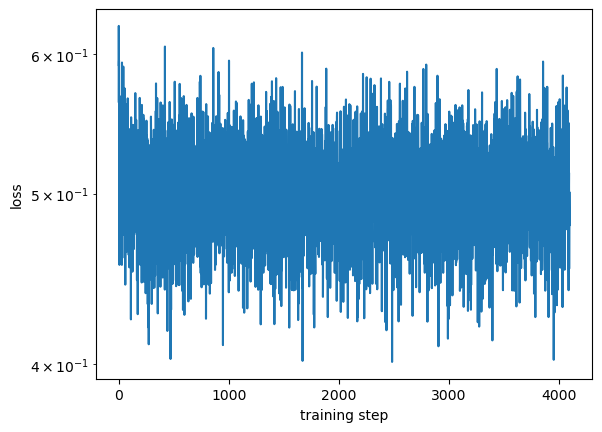

In [11]:
plt.figure()
plt.semilogy(np.array(train_losses))
plt.xlabel('training step')
plt.ylabel('loss')

Does this look as expected?

## Inspecting the trained model

In this simple one-dimensional case, we can also just evaluate the model on some test data.

The `torch.no_grad` context manager automatically stops tracing gradients.
This is useful to improve efficiency during validation, testing, and inference.

In [12]:
x_test = torch.linspace(-1, 1, 256)
y_test = target_fct(x_test)

with torch.no_grad() :
    ypred_test = regressor(x_test.reshape(-1, 1)).flatten()

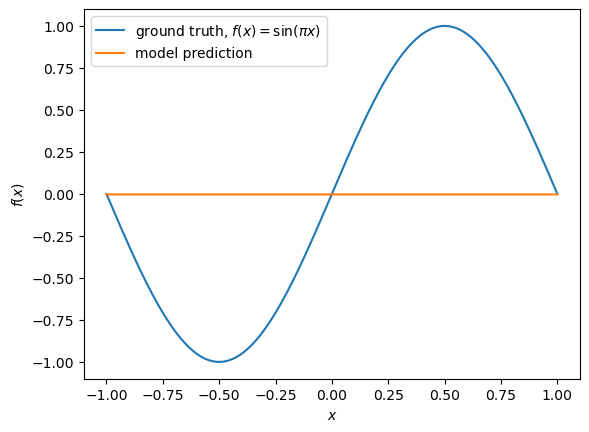

In [15]:
plt.figure()
plt.plot(x_test, y_test, label='ground truth, $f(x) = \sin(\pi x)$')
plt.plot(x_test, ypred_test, label='model prediction')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend()

Now, go back and figure out what went wrong.

Please keep `N_hidden` fixed for easier interpretation.
What do you observe as you increase `dim_hidden`?

Vanilla SGD is not a good optimizer. Try Adam.

## Bonus task

If you made it here and would like something to think about:
So far, we have worked with the domain $x \in [-1, 1]$.
Let's shift this domain to $x \in [10^3-1, 10^3+1]$.
Repeat the above steps with this new domain.
What do you find? If there are problems, how could you solve them?

(Note that $10^3 \pm 1$ is still quite accurately representable by 32-bit floats, which PyTorch uses by default.)

# 3. Classification of hand-written digits

So far, we have only looked at regression. The other big class of tasks is classification.

A classifier maps inputs to discrete classes.

Since the target space is discrete, we'll need to make some adjustments.
If there are $C$ classes, we'll let the output space of our model be $R^C$.
This way, we can interpret the $i$th element of the output vector as the (un-normalized) log-probability of the $i$th class.
Why is it convenient to work with log-probability instead of probability?

A popular loss function to optimize is the cross entropy (`nn.CrossEntropyLoss`).

In this exercise, we'll classify images of grey-scale hand-written digits (MNIST data set).
These images have $28 \times 28$ pixels
There are 10 classes (digits 0 through 9).
Using the `MultiLayerPerceptron` you wrote before, construct a classifier for this problem.

In [98]:
classifier = MultiLayerPerceptron(28*28, 10, 2, 16)

Our loss function is the cross entropy:

In [99]:
loss_fct = nn.CrossEntropyLoss()

The MNIST data is in a slightly idiosyncratic format, we read it as follows.

Note that the image pixels take values in $[0, 255]$. We know that normalization of inputs is important, so we get these back into $[-1, 1]$.

In [100]:
def read_images (file_name: str) -> torch.Tensor :
    with open(file_name, 'rb') as fp :
        magic, numimg, numrow, numcol = np.fromfile(fp, dtype='>i4', count=4)
        assert magic == 2051
        return torch.from_numpy(np.fromfile(fp, dtype='>u1').astype('f4').reshape(-1, numrow*numcol)) / 255

def read_labels (file_name: str) -> torch.Tensor :
    with open(file_name, 'rb') as fp :
        magic, numimg = np.fromfile(fp, dtype='>i4', count=2)
        assert magic == 2049
        return torch.from_numpy(np.fromfile(fp, dtype='>u1').astype('i8'))

In [101]:
base = '/Users/leander/a3n_2024/Lecture_Day2_Thiele'

In [102]:
train_images = read_images(f'{base}/train-images-idx3-ubyte')
train_labels = read_labels(f'{base}/train-labels-idx1-ubyte')

In [103]:
train_images.max()

tensor(1.)

Let's look at these images real quick:

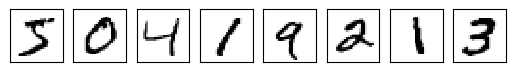

In [123]:
fig, ax = plt.subplots(ncols=8)
for ii, a in enumerate(ax) :
    a.matshow(train_images[ii].reshape(28, 28), cmap='Grays')
    a.set_xticks([])
    a.set_yticks([])

We use PyTorch built-ins to construct a convenient data loader.

In [105]:
batch_size = 256

In [106]:
train_set = torch.utils.data.TensorDataset(train_images, train_labels)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)

Now we only need an optimizer and then we're ready to train:

In [107]:
learning_rate = 1e-4
optimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate)

The training loop proceeds pretty much as before:

In [108]:
N_epochs = 32
train_losses = []

for epoch in tqdm.tqdm(range(N_epochs)) :
    for x, label in train_loader :
        optimizer.zero_grad()
        pred = classifier(x) # note that these predictions are *not* labels, as discussed before!
        loss = loss_fct(pred, label)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  5.02it/s]


Text(0, 0.5, 'training loss')

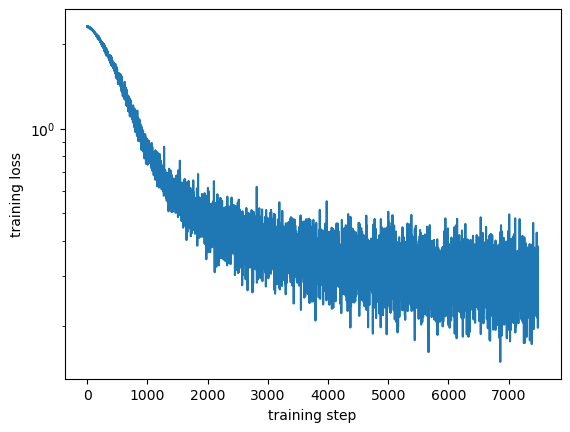

In [109]:
plt.figure()
plt.semilogy(train_losses)
plt.xlabel('training step')
plt.ylabel('training loss')

Now, let's test our trained model:

In [110]:
test_images = read_images(f'{base}/t10k-images.idx3-ubyte')
test_labels = read_labels(f'{base}/t10k-labels.idx1-ubyte')

In [111]:
with torch.no_grad() :
    test_pred = classifier(test_images).argmax(dim=1)

In [118]:
correct = test_labels == test_pred
print(f'Prediction accurate for {correct.sum() / len(correct) * 1e2: .1f} percent of testing samples')

Prediction accurate for  92.4 percent of testing samples


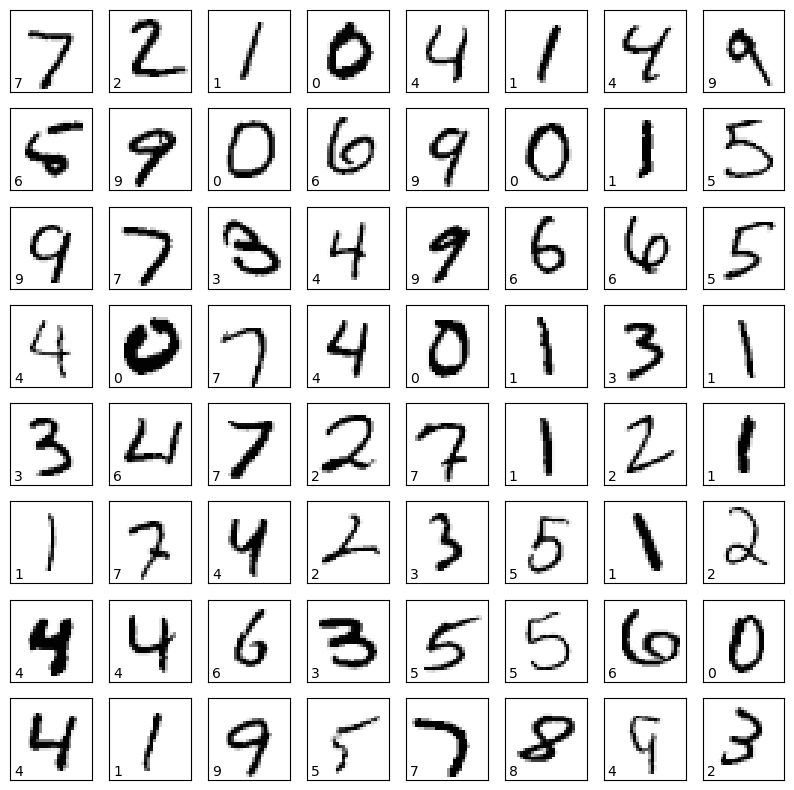

In [122]:
fig, ax = plt.subplots(ncols=8, nrows=8, figsize=(10, 10))
for ii, a in enumerate(ax.flatten()) :
    a.matshow(test_images[ii].reshape(28, 28), cmap='Grays')
    a.text(0.05, 0.05, f'{test_pred[ii]}', transform=a.transAxes)
    a.set_xticks([])
    a.set_yticks([])